In [1]:
import os
from dotenv import load_dotenv
_ = load_dotenv()

In [2]:
profile = {
    "name": "John",
    "full_name": "John Doe",
    "user_profile_background": "Senior software engineer leading a team of 5 developers",
}

In [3]:
prompt_instructions = {
    "triage_rules": {
        "ignore": "Marketing newsletters, spam emails, mass company announcements",
        "notify": "Team member out sick, build system notifications, project status updates",
        "respond": "Direct questions from team members, meeting requests, critical bug reports",
    },
    "agent_instructions": "Use these tools when appropriate to help manage John's tasks efficiently."
}

In [4]:
email = {
    "from": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "body": """
Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

In [5]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated
from langchain.chat_models import init_chat_model

In [6]:
llm = init_chat_model(model = "MFDoom/deepseek-r1-tool-calling:8b", model_provider = "ollama")

In [7]:
class Router(BaseModel):
    """Analyze the unread email and route it according to its content."""

    reasoning: str = Field(
        description="Step-by-step reasoning behind the classification."
    )
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore' for irrelevant emails, "
        "'notify' for important information that doesn't need a response, "
        "'respond' for emails that need a reply",
    )

In [8]:
llm_router = llm.with_structured_output(Router)

In [9]:
from prompts import triage_system_prompt, triage_user_prompt

In [10]:
from langchain_core.tools import tool

In [11]:
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}'"

In [12]:
@tool
def schedule_meeting(
    attendees: list[str], 
    subject: str, 
    duration_minutes: int, 
    preferred_day: str
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    return f"Meeting '{subject}' scheduled for {preferred_day} with {len(attendees)} attendees"


In [13]:
@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

#### Define tools for managing memory

In [14]:
from langgraph.store.memory import InMemoryStore
from langchain.embeddings import OllamaEmbeddings

In [15]:
ollama_embedding = OllamaEmbeddings(model="mxbai-embed-large:latest")

store = InMemoryStore(
    index = {"embed" : "openai:text-embedding-3-small"}
)

C:\Users\OON YEE SEM\AppData\Local\Temp\ipykernel_31520\644661452.py:1: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaEmbeddings``.
  ollama_embedding = OllamaEmbeddings(model="mxbai-embed-large:latest")
C:\Users\OON YEE SEM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\langgraph\store\base\embed.py:95: LangChainBetaWarning: The function `init_embeddings` is in beta. It is actively being worked on, so the API may change.
  return init_embeddings(embed)


In [16]:
from langmem import create_manage_memory_tool, create_search_memory_tool

In [17]:
manage_memory_tool = create_manage_memory_tool(
    namespace = (
        "email_assistant",
        "{langgraph_user_id}",
        "collection"
 
    )
)
search_memory_tool = create_search_memory_tool(
    namespace = (
        "email_assistant",
        "{langgraph_user_id}",
        "collection"
    )
)

In [18]:
agent_system_prompt_memory = """
< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage {name}'s communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
4. manage_memory - Store any relevant information about contacts, actions, discussion, etc. in memory for future reference
5. search_memory - Search for any relevant information that may have been stored in memory
</ Tools >

< Instructions >
{instructions}
</ Instructions >
"""

In [19]:
def create_prompt(state):
    return [
        {
            "role" : "system",
            "content" : agent_system_prompt_memory.format(
                instructions=prompt_instructions["agent_instructions"],
                **profile
            )
        }
    ] + state['messages']

In [20]:
from langgraph.prebuilt import create_react_agent
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI

In [21]:
tools = [
    write_email, 
    schedule_meeting,
    check_calendar_availability,
    manage_memory_tool,
    search_memory_tool
]

# model = ChatOllama(model = "MFDoom/deepseek-r1-tool-calling:8b")
    
model = ChatOpenAI(model="gpt-4o")
response_agent = create_react_agent(
    model = model,
    tools = tools,
    prompt = create_prompt,
    store = store,
)

In [22]:
config = {"configurable": {"langgraph_user_id": "lance2"}}

In [23]:
response = response_agent.invoke(
    {"messages": [{"role": "user", "content": "Jim is my friend"}]},
    config=config
)

In [24]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Jim is my friend
================================== Ai Message ==================================
Tool Calls:
  manage_memory (call_J7gB8cJBv0rcSLRhD6ajV4OX)
 Call ID: call_J7gB8cJBv0rcSLRhD6ajV4OX
  Args:
    content: Jim is John's friend.
    action: create
================================= Tool Message =================================
Name: manage_memory

created memory ee9ef57e-568d-4983-b2c9-c18f0b0e0a15
================================== Ai Message ==================================

I've noted that Jim is your friend. If there's anything specific you need to do involving Jim, just let me know!


In [25]:
response = response_agent.invoke(
    {"messages": [{"role": "user", "content": "who is jim?"}]},
    config=config
)

In [26]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

who is jim?
================================== Ai Message ==================================
Tool Calls:
  search_memory (call_m9al5sxomZ2L0C8LjcTTvoIR)
 Call ID: call_m9al5sxomZ2L0C8LjcTTvoIR
  Args:
    query: Jim
================================= Tool Message =================================
Name: search_memory

[{"namespace": ["email_assistant", "lance2", "collection"], "key": "ee9ef57e-568d-4983-b2c9-c18f0b0e0a15", "value": {"content": "Jim is John's friend."}, "created_at": "2025-03-18T14:24:47.605410+00:00", "updated_at": "2025-03-18T14:24:47.605410+00:00", "score": 0.43429759750644736}]
================================== Ai Message ==================================

Jim is John's friend.


In [27]:
store.list_namespaces()

[('email_assistant', 'lance2', 'collection')]

In [28]:
store.search(('email_assistant', 'lance2', 'collection'))

[Item(namespace=['email_assistant', 'lance2', 'collection'], key='ee9ef57e-568d-4983-b2c9-c18f0b0e0a15', value={'content': "Jim is John's friend."}, created_at='2025-03-18T14:24:47.605410+00:00', updated_at='2025-03-18T14:24:47.605410+00:00', score=None)]

#### Create the rest of the agent

In [29]:
from langgraph.graph import add_messages

class State(TypedDict):
    email_input: dict
    messages: Annotated[list, add_messages]

In [30]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from typing import Literal
from IPython.display import Image, display

In [31]:
def triage_router(state : State) -> Command[
    Literal["response_agent",  "__end__"]
]:
    author = state['email_input']['author']
    to = state['email_input']['to']
    subject = state['email_input']['subject']
    email_thread = state['email_input']['email_thread']

    system_prompt = triage_system_prompt.format(
        full_name=profile["full_name"],
        name=profile["name"],
        user_profile_background=profile["user_profile_background"],
        triage_no=prompt_instructions["triage_rules"]["ignore"],
        triage_notify=prompt_instructions["triage_rules"]["notify"],
        triage_email=prompt_instructions["triage_rules"]["respond"],
        examples=None
    )
    
    user_prompt = triage_user_prompt.format(
        author=author, 
        to=to, 
        subject=subject, 
        email_thread=email_thread
    )
    
    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )
    
    if result.classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email {state['email_input']}",
                }
            ]
        }
    elif result.classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        update = None
        goto = END
        
    elif result.classification == "notify":
        # If real life, this would do something else
        print("🔔 Classification: NOTIFY - This email contains important information")
        update = None
        goto = END
        
    else:
        raise ValueError(f"Invalid classification: {result.classification}")
    
    return Command(goto=goto, update=update)

In [32]:
email_agent = StateGraph(State)
email_agent = email_agent.add_node(triage_router)
email_agent = email_agent.add_node("response_agent", response_agent)
email_agent = email_agent.add_edge(START, "triage_router")
email_agent = email_agent.compile(store=store)

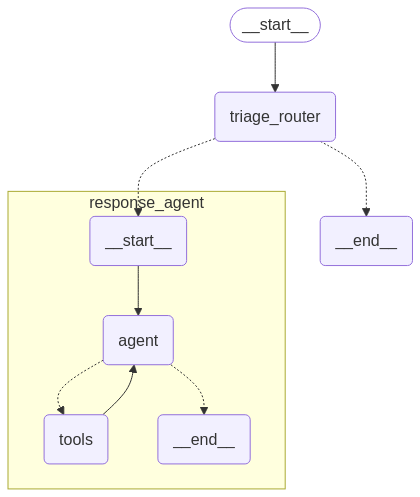

In [33]:
display(Image(email_agent.get_graph(xray=True).draw_mermaid_png()))

In [34]:
email_input = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

In [35]:
response = email_agent.invoke(
    {"email_input": email_input},
    config=config
)

📧 Classification: RESPOND - This email requires a response


In [36]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': "Hi John,\n\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\n\nThanks!\nAlice"}
================================== Ai Message ==================================
Tool Calls:
  write_email (call_feDKTplCvJIq04vjgpxeUN7I)
 Call ID: call_feDKTplCvJIq04vjgpxeUN7I
  Args:
    to: alice.smith@company.com
    subject: Re: Quick question about API documentation
    content: Hi Alice,

Thank you for bringing this to our attention. The missing endpoints /auth/refresh and /auth/validate should indeed be i

#### Try a follow-up email

In [37]:
email_input = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Follow up",
    "email_thread": """Hi John,

Any update on my previous ask?""",
}

In [38]:
response = email_agent.invoke({"email_input": email_input}, config=config)

📧 Classification: RESPOND - This email requires a response


In [39]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Follow up', 'email_thread': 'Hi John,\n\nAny update on my previous ask?'}
================================== Ai Message ==================================
Tool Calls:
  search_memory (call_GtaqUR77jWPa8lDzwk43rJM8)
 Call ID: call_GtaqUR77jWPa8lDzwk43rJM8
  Args:
    query: Alice Smith previous ask
    limit: 5
  search_memory (call_4j21cDYScHRggM1ueCK66PcZ)
 Call ID: call_4j21cDYScHRggM1ueCK66PcZ
  Args:
    query: John Doe and Alice Smith
    limit: 5
================================= Tool Message =================================
Name: search_memory

[{"namespace": ["email_assistant", "lance2", "collection"], "key": "ee9ef57e-568d-4983-b2c9-c18f0b0e0a15", "value": {"content": "Jim is John's friend."}, "created_at": "2025-03-18T14:24:47.605410+00:00", "updated_at": "2025-03-18T14: